# Estimating expressibility of different connectivity topologies: alternative ansatz

In this notebook I'll try a different ansatz to verify if only one layer can present differences regarding the topology of connections. If it remains close to the results obtained for only one layer, the chosen circuit structure will be the simplest one.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.special import rel_entr

#np.random.seed(42)

In [2]:
wires = 4 #number of qubits
dev = qml.device("default.qubit", wires=wires, shots=None)

# Circuits histogram

In [3]:
def fidel_histogram(binsnumb, samples, circuit, nlayers):
    fidel_vector = []
    for i in range(samples):
        #angles1 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
        #             requires_grad=True)
        #angles2 = np.array([np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
        #             requires_grad=True)
        
        angles1 = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)],
                           requires_grad = True)
        
        angles2 = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)], 
                           requires_grad = True)
        
        state1 = circuit(angles1)
        state2 = circuit(angles2)
        
        F = np.abs( np.dot(state1, state2) )**2
        
        fidel_vector.append(F)
        
    fidel_vector = np.asarray(fidel_vector)
    
    binsize = 1.0/binsnumb
    bins = np.arange(0, 1. + binsize, binsize)
    
    histogram, bins = np.histogram(fidel_vector, bins=bins)[0]/samples, np.histogram(fidel_vector, bins=bins)[1]
    
    return histogram, bins

## Number of layers

In [4]:
nlayers = 1

# Circuits definition

## Identity circuit reference

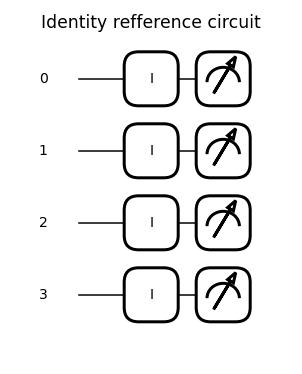

In [5]:
def identity(rots):
    for i in range(wires):
        qml.Identity(wires = [i])
    return qml.state()

identity_circuit = qml.QNode(identity, dev)

angles = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)],
                           requires_grad = True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(identity_circuit, decimals=2)(angles)
fig1.suptitle("Identity refference circuit", fontsize='xx-large')
plt.show()

## No connections

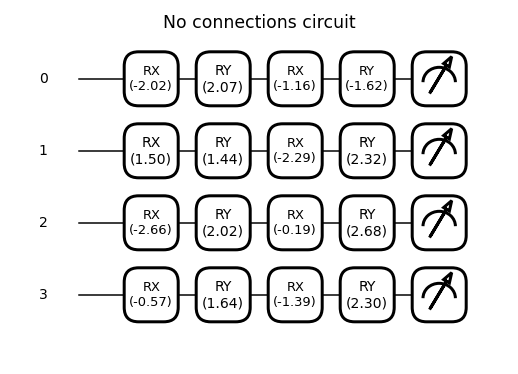

In [6]:
#Layer definition

def layer_noconnec(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
        qml.RX(rots[2][i], wires=[i])
        qml.RY(rots[3][i], wires=[i])
        
#Circuit definition
        
def noconnec(rots):
    qml.layer(layer_noconnec, nlayers, rots)
    return qml.state()

noconnec_circuit = qml.QNode(noconnec, dev)

angles = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)],
                           requires_grad = True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(noconnec_circuit, decimals=2)(angles)
fig1.suptitle("No connections circuit", fontsize='xx-large')
plt.show()

## Linear connections

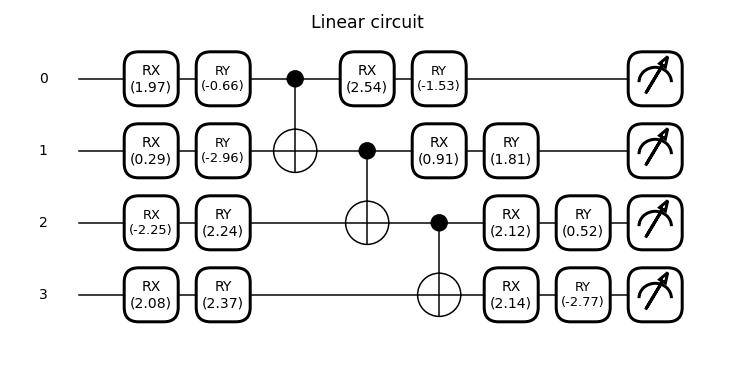

In [7]:
#Layer definition

def layer_linear(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    for i in range(wires):
        qml.RX(rots[2][i], wires=[i])
        qml.RY(rots[3][i], wires=[i])

#Circuit definition

def linear(rotations):
    qml.layer(layer_linear, nlayers, rotations)
    return qml.state()

linear_circuit = qml.QNode(linear, dev)

angles = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)],
                           requires_grad = True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(linear_circuit, decimals=2)(angles)
fig1.suptitle("Linear circuit", fontsize='xx-large')
plt.show()

## Ring connections ('oriented')

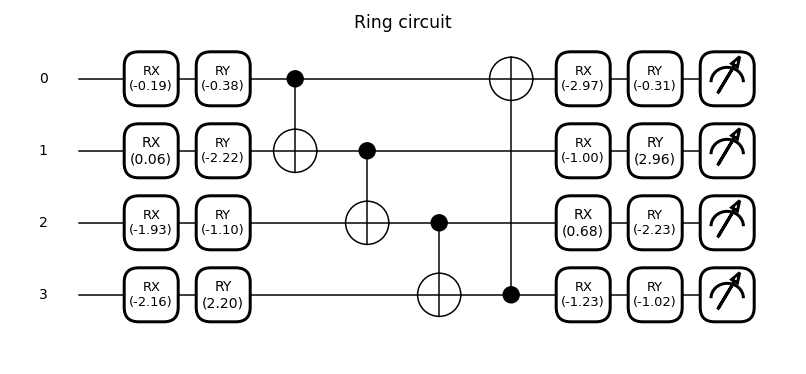

In [8]:
#Layer definition

def layer_ring(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="chain")
    qml.CNOT(wires=[wires-1,0])
    for i in range(wires):
        qml.RX(rots[2][i], wires=[i])
        qml.RY(rots[3][i], wires=[i])

# Circuit definition:    

def ring(rotations):
    qml.layer(layer_ring, nlayers, rotations)
    return qml.state()


ring_circuit = qml.QNode(ring, dev)

angles = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)],
                           requires_grad = True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(ring_circuit, decimals=2)(angles)
fig1.suptitle("Ring circuit", fontsize='xx-large')
plt.show()

## Star connections

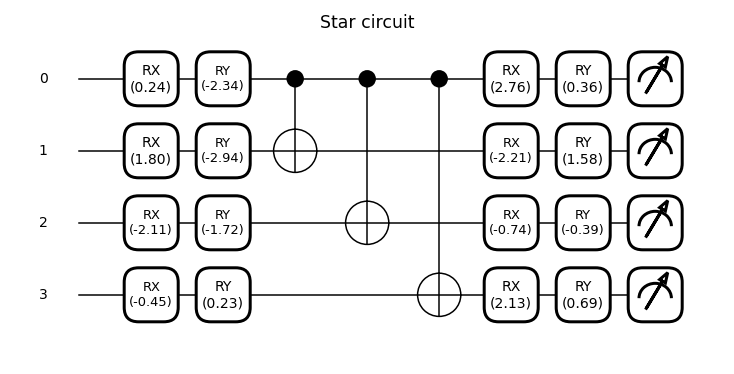

In [9]:
#Layer definition

def layer_star(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    for i in range(wires-1):
        qml.CNOT(wires = [0, i+1])
    for i in range(wires):
        qml.RX(rots[2][i], wires=[i])
        qml.RY(rots[3][i], wires=[i])


#Circuit definition

def star(rotations):
    qml.layer(layer_star, nlayers, rotations)
    return qml.state()

star_circuit = qml.QNode(star, dev)

angles = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)],
                           requires_grad = True)

qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(star_circuit, decimals=2)(angles)
fig1.suptitle("Star circuit", fontsize='xx-large')
plt.show()

## All-to-all connections

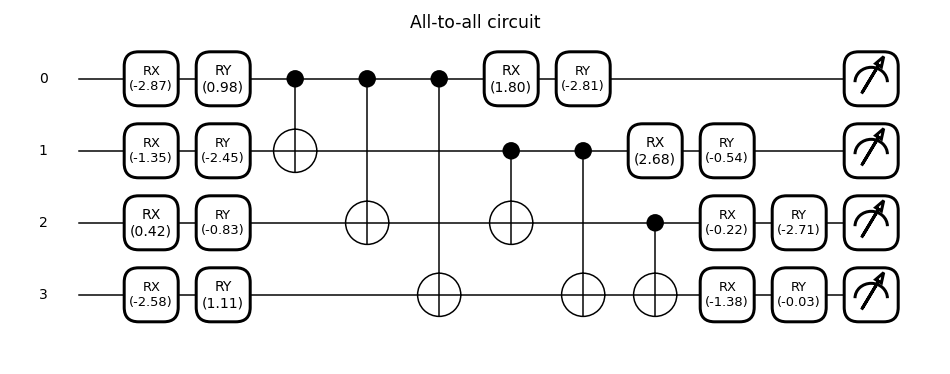

In [10]:
#Layer definition

def layer_alltoall(rots):
    for i in range(wires):
        qml.RX(rots[0][i], wires=[i])
        qml.RY(rots[1][i], wires=[i])
    qml.broadcast(qml.CNOT, wires=range(wires), pattern="all_to_all")
    for i in range(wires):
        qml.RX(rots[2][i], wires=[i])
        qml.RY(rots[3][i], wires=[i])

# Circuit Definition:

def alltoall(rotations):
    qml.layer(layer_alltoall, nlayers, rotations)
    return qml.state()

alltoall_circuit = qml.QNode(alltoall, dev)

angles = np.array( [ [[np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)],
                   [np.random.uniform(low=-np.pi, high=np.pi) for i in range(wires)]] for j in range(nlayers)],
                           requires_grad = True)


qml.drawer.use_style('black_white')
fig1, ax1 = qml.draw_mpl(alltoall_circuit, decimals=2)(angles)
fig1.suptitle("All-to-all circuit", fontsize='xx-large')
plt.show()

# Haar distributed and circuits distributed histograms

In this section we define the parameters that are going to be used: sample size and number of bins (subdivisions of intervals in the histogram). The width parameter is only used to plot the graphs.

After that, we build the circuits and Haar histograms and compare them using the relative entropy. The values are going to be ploted together in a single graph using only one layer of each circuit.

## Parameters

In [11]:
samplesize = 500
nbins = 75
width = 1.0/nbins

## Identity circuit refference

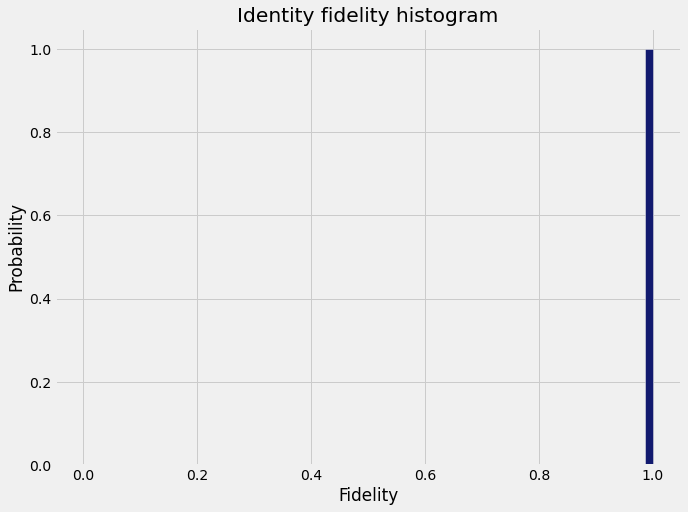

In [12]:
identity_hist, bins = fidel_histogram(nbins, samplesize, identity_circuit, nlayers)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, identity_hist, color = '#121A6F', width = width)

ax.title.set_text('Identity fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## No connection

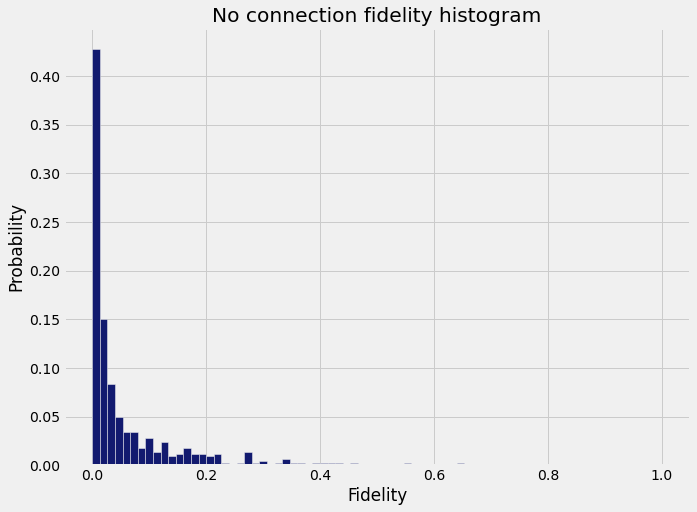

In [13]:
noconnec_hist, bins = fidel_histogram(nbins, samplesize, noconnec_circuit, nlayers)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, noconnec_hist, color = '#121A6F', width = width)

ax.title.set_text('No connection fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Linear

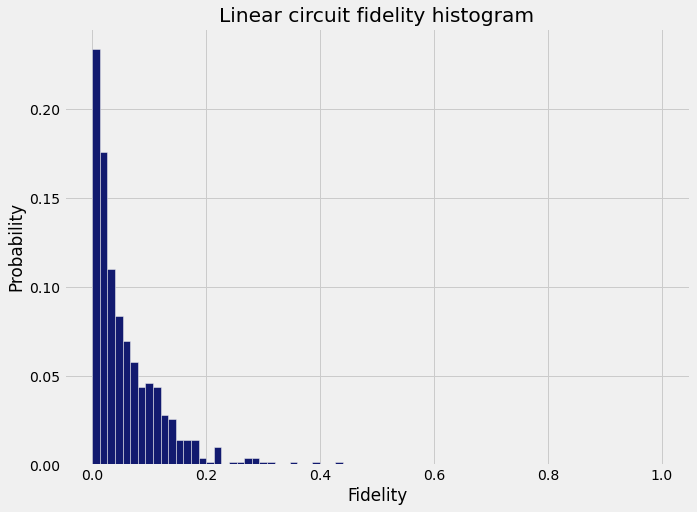

In [14]:
linear_hist, bins = fidel_histogram(nbins, samplesize, linear_circuit, nlayers)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, linear_hist, color = '#121A6F', width = width)

ax.title.set_text('Linear circuit fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Ring ('oriented')

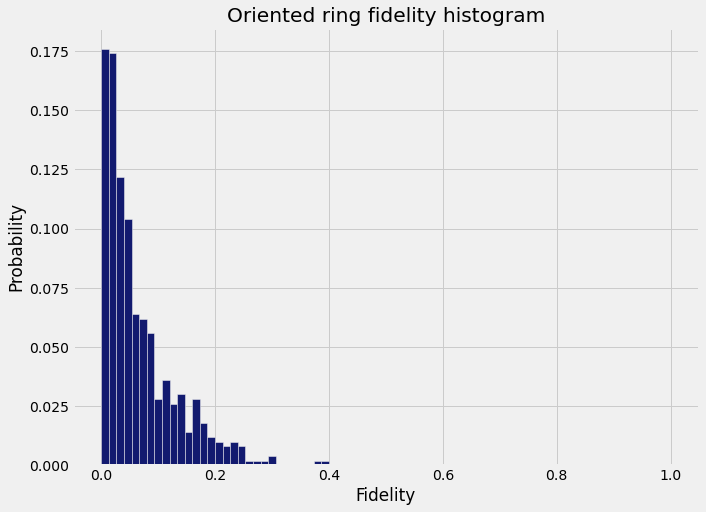

In [15]:
ring_hist, bins = fidel_histogram(nbins, samplesize, ring_circuit, nlayers)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, ring_hist, color = '#121A6F', width = width)

ax.title.set_text('Oriented ring fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Star

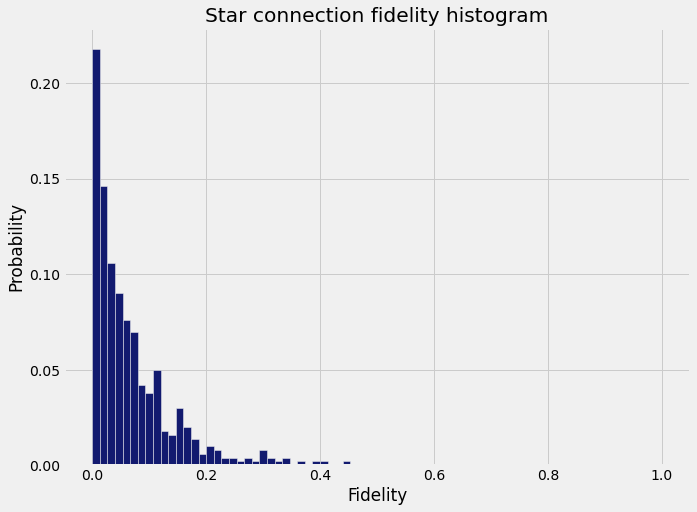

In [16]:
star_hist, bins = fidel_histogram(nbins, samplesize, star_circuit, nlayers)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, star_hist, color = '#121A6F', width = width)

ax.title.set_text('Star connection fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## All-to-all

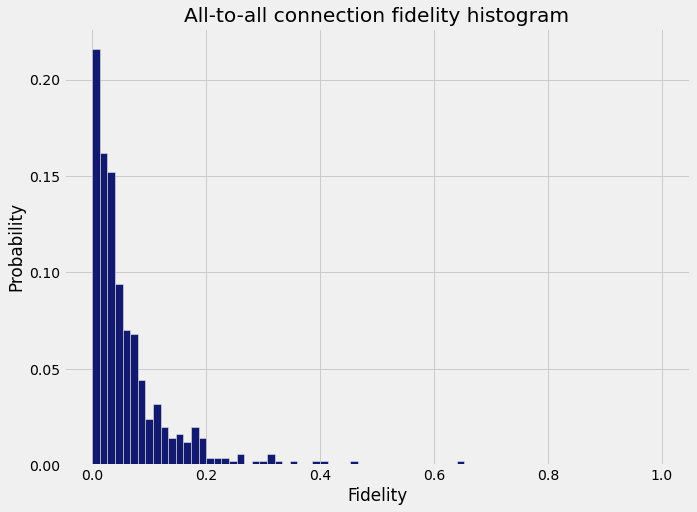

In [17]:
alltoall_hist, bins = fidel_histogram(nbins, samplesize, alltoall_circuit, nlayers)

#Just for the appearance
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1]+width/2, alltoall_hist, color = '#121A6F', width = width)

ax.title.set_text('All-to-all connection fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

## Haar

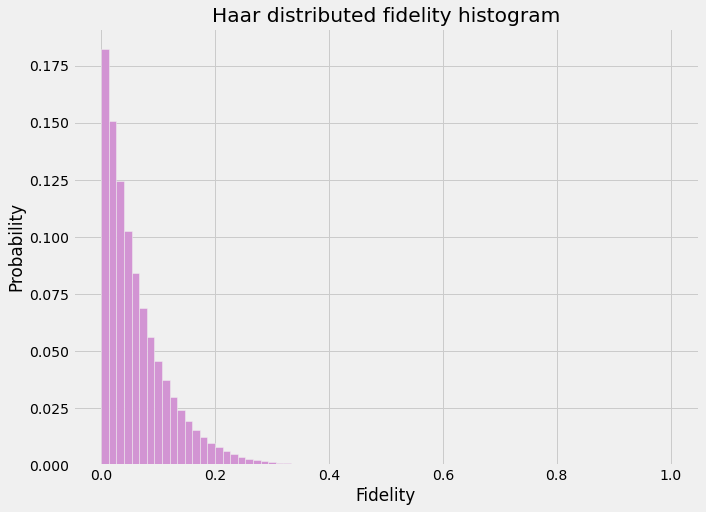

In [18]:
N = 2**wires #dimension of the Hilbert space

histogram_Haar = []

for i in range(nbins):
    histogram_Haar.append(  (1-bins[i])**(N-1) - (1-bins[i+1])**(N-1)  )
    
fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.bar(bins[:-1] + width/2, histogram_Haar, color = '#D294D3', width = width)

ax.title.set_text('Haar distributed fidelity histogram')
ax.set_xlabel('Fidelity')
ax.set_ylabel('Probability')

plt.show()

# Expressibility values

## Identity refference

In [19]:
D_KL_identity = sum( rel_entr(identity_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.3f nats' % D_KL_identity)

Relative entropy S(Empir||Haar) = 64.762 nats


## No connection

In [20]:
D_KL_noconnec = sum( rel_entr(noconnec_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.3f nats' % D_KL_noconnec)

Relative entropy S(Empir||Haar) = 0.301 nats


## Linear

In [21]:
D_KL_linear = sum( rel_entr(linear_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.3f nats' % D_KL_linear)

Relative entropy S(Empir||Haar) = 0.042 nats


## Ring ('oriented')

In [22]:
D_KL_ring = sum( rel_entr(ring_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.3f nats' % D_KL_ring)

Relative entropy S(Empir||Haar) = 0.031 nats


## Star

In [23]:
D_KL_star = sum( rel_entr(star_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.3f nats' % D_KL_star)

Relative entropy S(Empir||Haar) = 0.050 nats


## All-to-all

In [24]:
D_KL_alltoall = sum( rel_entr(alltoall_hist, histogram_Haar) )
print('Relative entropy S(Empir||Haar) = %.3f nats' % D_KL_alltoall)

Relative entropy S(Empir||Haar) = 0.069 nats


# Expressibilities graph

Text(0, 0.5, 'Expressibility (nats)')

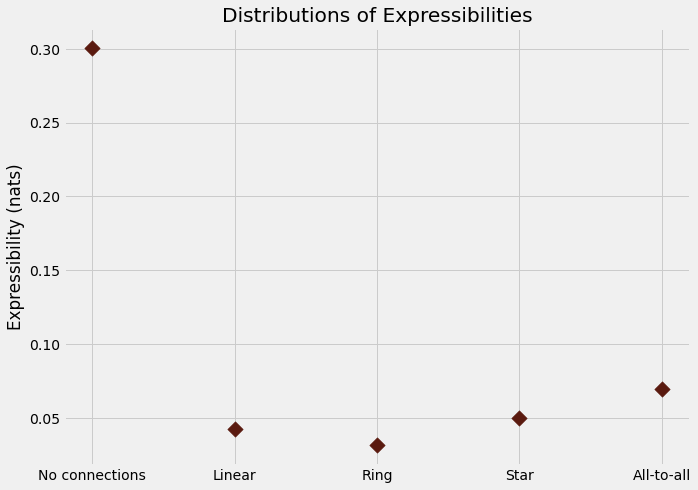

In [25]:
# expressibilities
express = [D_KL_noconnec, D_KL_linear, D_KL_ring, D_KL_star, D_KL_alltoall]

# circuits type
circuits = ["No connections", "Linear", "Ring", "Star", "All-to-all"]

fig = plt.figure(figsize = (10, 7.5))
ax = fig.add_subplot(111)

ax.scatter(circuits, express, s = 120, marker = 'D', color="#5A1A0F")

ax.title.set_text('Distributions of Expressibilities')
ax.set_ylabel('Expressibility (nats)')

In [26]:
f = open("expressibility_ansatz2_qubits{0}_layers{1}_samples{2}.txt".format(wires,nlayers, samplesize), "w")

print('Circuit,Expressibility', file = f)
print('No connections,', D_KL_noconnec, file = f)
print('Linear,', D_KL_linear, file = f)
print('Ring,', D_KL_ring, file = f)
print('Star,', D_KL_star, file = f)
print('All-to-all,', D_KL_alltoall, file = f)